In [30]:
# Version 7.0

import math
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    

    def __sub__(self, other):
        return self + (-1.0 * other)

    '''
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), "-")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    '''
        
    def __rsub__(self, other):
        return other + (-1.0 * self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    '''
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), "/")

        def _backward():
            self.grad += (1.0/other.data) * out.grad
            other.grad += ((-1 * self.data) / (other.data**2)) * out.grad

        out._backward = _backward

        return out
    '''
    def __rtruediv__(self, other): # self = Value, other = int/float
        return other * self.data ** -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad

        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError("Supporting int and float powers only for now :(")
        out = Value(self.data ** other, (self, ), f'** {other}' )

        def _backward():
            self.grad += (other * (self.data ** (other - 1.0))) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build_topo(child)
                topo.append(root)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [32]:
### DRAW THE FUNCTION GRAPH

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    nodes.add(root)
    def build(root):
        for child in root._prev:
            nodes.add(child)
            edges.add((child, root))
            build(child)
    
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: Draw the graph from left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(uid, "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(uid+n._op, n._op)
            dot.edge(uid+n._op, uid)

    for e in edges:
        dot.edge(str(id(e[0])), str(id(e[1]))+e[1]._op)

    return dot

In [33]:
# Inputs
x1 = Value(2.0); x1.label = 'x1'
x2 = Value(0.0); x2.label = 'x2'

# Weights
w1 = Value(-3.0); w1.label = 'w1'
w2 = Value(1.0); w2.label = 'w2'

# Bias
b = Value(6.8813735870195432); b.label = 'b'

# o = x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 - x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' 

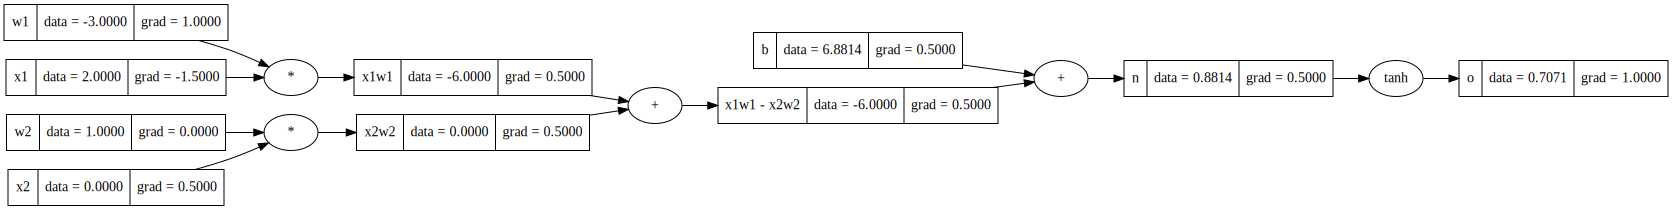

In [34]:
o.backward()
draw_graph(o)

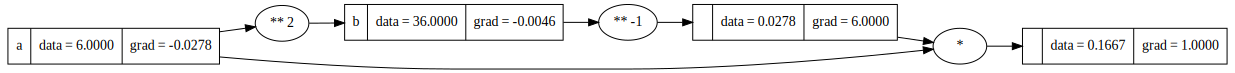

In [35]:
a = Value(6.0, label = 'a')
b = a**2; b.label='b'
c = a / b

c.backward()
draw_graph(c)